本节课我们来看一下，注意力分数的具体实现细节，也就是我们该如何设计一个更加合理的注意力权重（通过权重去计算分数）

整个注意力机制的大致思想可以参考李沐老师的这节课，有个图比较好去理解

* 第一种现代的注意力分数的设计方法是可加性attention，其实也就是在整个公式里面加上了三个可学习的权重，具体的公式解释还是看李沐老师的视频
    * 也可以这么解释，其实就是把key和query通过权重加在一起，然后扔到一个单隐藏层的MLP里面去
* 另一种方法是当query和key具有相同的长度的时候，通常会使用相乘得到内积的方法来做注意力

* 其实注意力分数就是query和key的相似度，而注意力权重则是注意力分数做了一个softmax（毕竟权重希望小于1，加起来等于1）

下面我们来看看注意力打分到底是如何具体实现的

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#@save
# 这里的masked_softmax其实和我们昨天弄过的masked_loss是一样的东西
# 也就是超出我们规定长度的东西，我们给他一个很小很小的值，这样softmax出来会直接变成0
# 像这里我们就给了一个1e6
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5487, 0.4513, 0.0000, 0.0000],
         [0.6847, 0.3153, 0.0000, 0.0000]],

        [[0.1681, 0.4069, 0.4251, 0.0000],
         [0.4802, 0.2492, 0.2706, 0.0000]]])

In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3388, 0.3079, 0.3533, 0.0000]],

        [[0.5170, 0.4830, 0.0000, 0.0000],
         [0.2144, 0.1489, 0.2591, 0.3777]]])

In [5]:
#@save
# 这里加性注意力其实没啥特殊的，四舍五入和MLP是一样的
# 主要是注意forward函数里面的数据形状变换
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [6]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

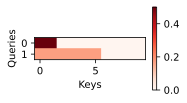

In [7]:
# 这里我们每个key是一样的，所以注意力权重是相同的
# 但是看个数，可以发现我们个数是与我们的valid len相同的
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [8]:
#@save
# 接下来就是第二种注意力算法，就是直接求点积，然后缩放一下的那种
# 这玩意的好处就是完全没有任何可学习参数
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [9]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

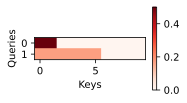

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

其实这两节看下来，注意力机制的数学逻辑并不复杂，总的来说其实就是我们想要给我们手中的数据加上一个权重，这样我们新的样本加入进来我们就能得到更加高置信度的结果
* 注意力机制的根本核心元素其实就是三点，key、query、value，其中key、value就可以看做是训练数据中的x、y，而query则是推理当中的x
* 而注意力机制就是通过判断query和key的“距离”，从而人为的给value一个权重，这样就不像我们之前用简单的conv、pool之类的，所有的value都是一个权重了
* 虽然我们前面用conv、MLP啥的，我们会去学习权重，但是要注意这里我们学习到的权重是针对特征的，也就是每个特征我们认为谁更重要
* 但是注意力机制则是利用心理学中的概念，我们直接去更加关注我们想要的那种东西，从样本的维度去增加权重
* 神经网络本身就能够学习特征权重，这样再加上样本权重，我们能够更好的学习到训练数据中的pattern，从而表征出抽象的函数关系
* 这也是注意力机制我认为最为关键的作用
* 前面的内容我们是从单纯的数学逻辑上理解注意力机制，那放到dl里面注意力机制到底怎么工作，下面我们会开始讲